In [1]:
from ApylabradosModule import Pawns,Word,FrequencyTable,Board,Dictionary
import ApylabradosModule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

¡¡¡Bienvenido al juego Apailabrados de Andres!!!

Inprucciones del juego :
 Introduce la palabra en Mayuscula
 La primera palabra siempre debe pasar por la coordenada central
 A diferencia de la primera palabra, tienes que aprovechar alguna letra para formar la nueva
 solo tienes dos opciones para la direccion V (vertical) H (horizontal)


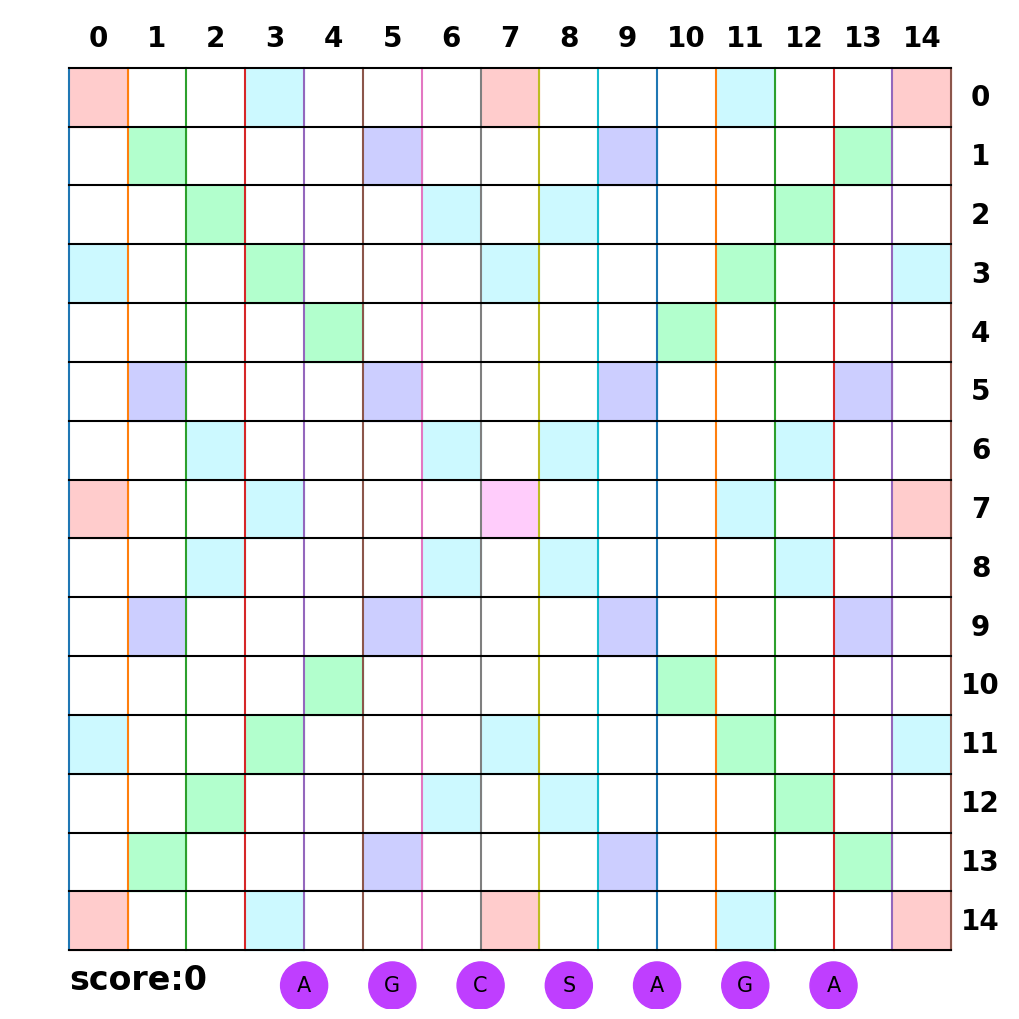

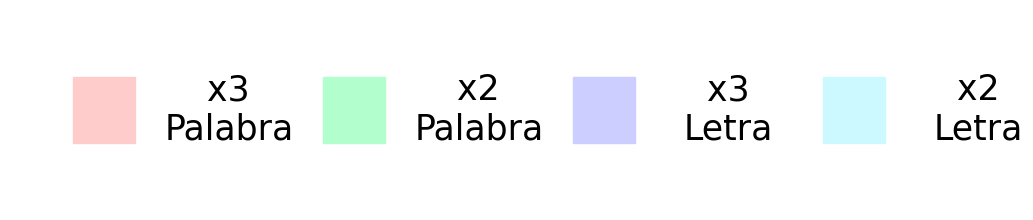

¿Que deseas hacer ?  
 
 Para continuar, introduce: ENTERWORD
 Para consultar fichar, introduce: MYPAWNS
 Para consultar puntos actuales, introduce: MYSCORE
 Para consultar puntos de cada ficha, introduce: PAWNSPOINTS
 Para obtener Ayuda con la posible palabra, introduce: HELPWORD
 Para obtener Ayuda con la Legenda, introduce: HELPLEGEND
 Para Salir del juego, introduce: QUITGAME
 


 HELPWORD


Estas son tus posibles palabras a formar: 
A , AC , AS ,
C , CA , G , GA ,
GAGS , GAS , S , SA ,
SAC , ¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 ENTERWORD


Introduce tu palabra:


 GAS


¿Que deseas hacer ?  
 
 Para continuar, introduce: ENTERPOSITION
 Para cambiar la palabra, introduce: ENTERWORD
 Para consultar fichar, introduce: MYPAWNS
 Para consultar puntos actuales, introduce: MYSCORE
 Para consultar puntos de cada ficha, introduce: PAWNSPOINTS
 Para obtener Ayuda con la posible palabra, introduce: HELPWORD
 para obtener Ayuda con la posible Posicion, introduce: HELPPOS
 Para obtener Ayuda con la Legenda, introduce: HELPLEGEND
 Para Salir del juego, introduce: QUITGAME
 


 ENTEPOSITION


¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 7


¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 ENTERPOSITION
Indroduce coordenada de la fila:  7
Indroduce coordenada de la columna:  7
Indroduce la direccion:  v


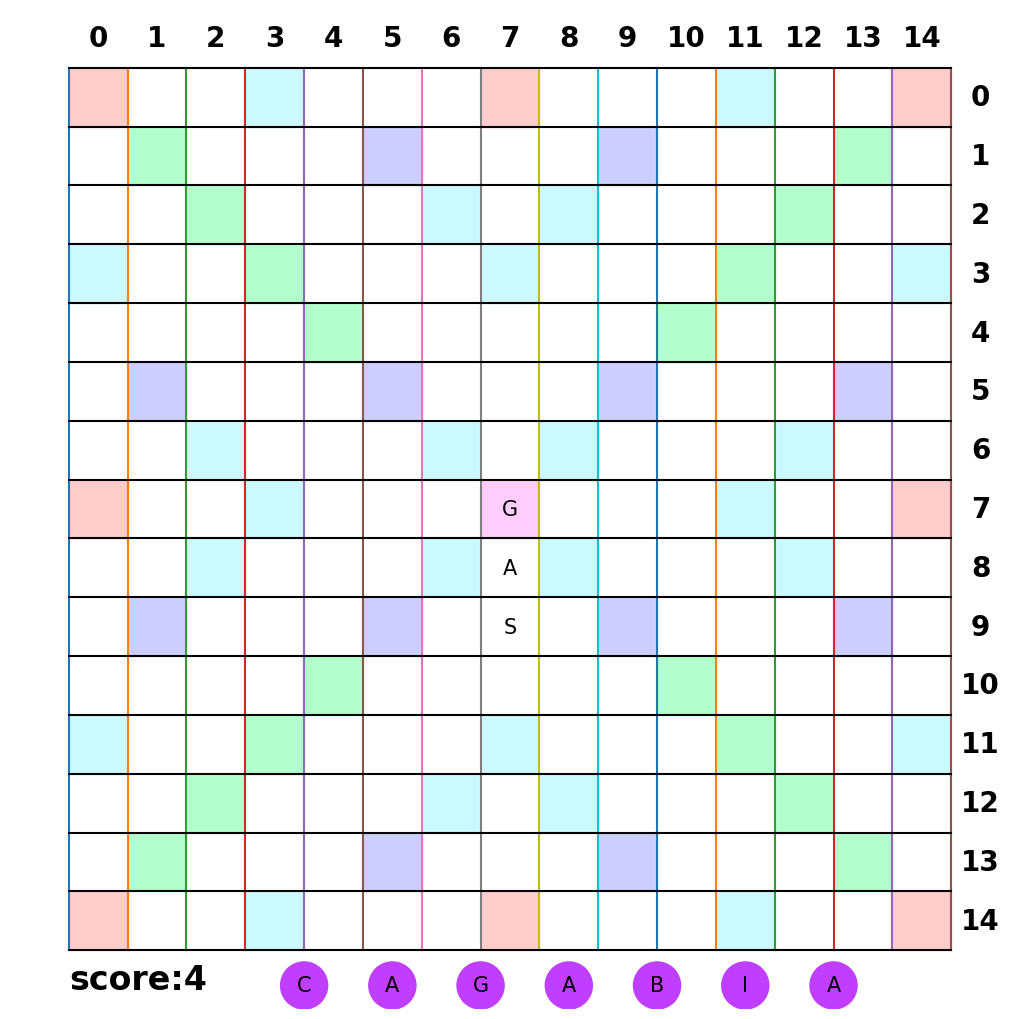

puntos: 4
¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 HELPLEGED


¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 HELPLEGEND


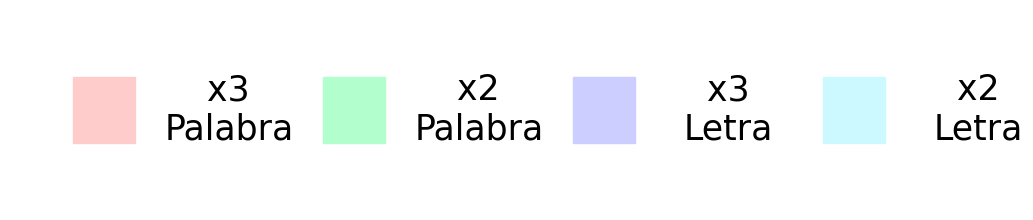

¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 HELPWORD


Estas son tus posibles palabras a formar: 
AGAI BAG BIG
G GA GAB GI
GIG A AC AGAI
AI BA BAC BAG
CA CAB GA GAB
ICA AS ASIA BAGS
BAS BASA BIAS CABS
GAS IS S SA
SAC SI ¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 ENTERWORD


Introduce tu palabra:


 BAS


¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 ENTERPOSITION
Indroduce coordenada de la fila:  9
Indroduce coordenada de la columna:  5
Indroduce la direccion:  H


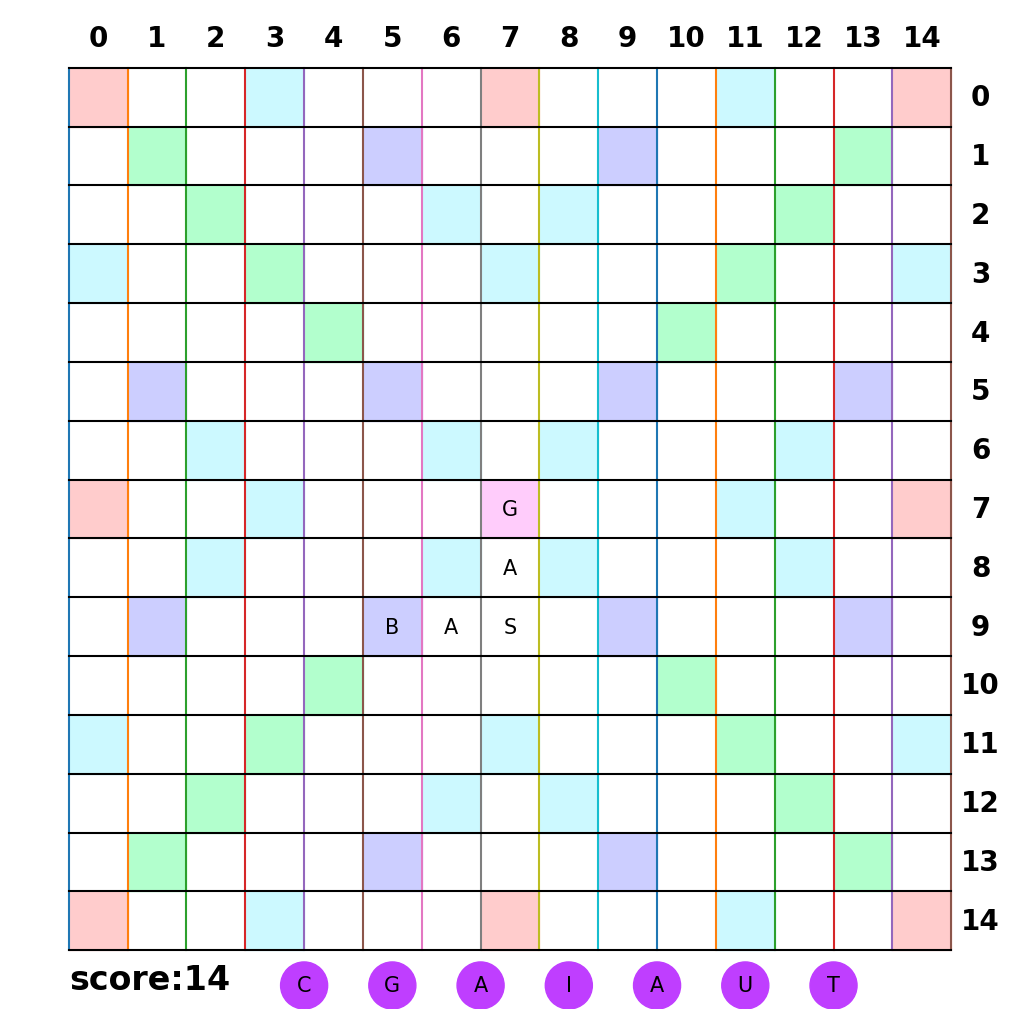

puntos: 14
¿Que deseas hacer ?  (introduce SHOWHELP para ver las opciones)


 QUITGAME


Fin del Juego
has conseguido 14 de puntos en esta partida


In [2]:
ApylabradosModule.startGame()
while not ApylabradosModule.end and ApylabradosModule.bag_of_pawns.getTotalPawns()>0:
    ApylabradosModule.showOption()
if ApylabradosModule.bag_of_pawns.getTotalPawns()<=0:
    print("¡¡¡Te has quedado sin fichas!!!")
    print("Fin del juego")
print(f"has conseguido {Board.score} de puntos en esta partida")